# BuenaOla Coding Challenge

### Contents

- [Imports](#Imports)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Correlation Between Data & Target](#Correlation-between-variables-and-market-cap)
- [Market Cap vs. Environmental Costs](#Market-Cap-vs.-Environmental-Cost)
- [Sentiment Analysis](#Sentiment-Analysis)
- [Modeling](#Modeling)
- [Predictions & Residuals](#Predictions-&-Residuals)
- [Conclusions](#Conclusions)

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import regex as re

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from bs4 import BeautifulSoup

/Users/aerikasong/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


#### Note:

If time permits, I also plan to scrape Glassdoor Employee Reviews and News Header Results from Google News and analyze the general sentiment. I will go ahead and establish the code as much as I can for the sentiment analysis, but ultimately, I won't be able to perform the sentiment analysis unless I have the scraped data for all 35 companies.

In [2]:
# Data Imports:

# Environmental Impact Data
env_df = pd.read_excel('../data/corporate_environmental_impact_v2.xlsx')

# Financial/Stock Data
stock_df = pd.read_excel('../data/russell_2000_stock_data.xlsx')

# Employee Data & ESG Scores
employee_df = pd.read_excel('../data/employee_data.xlsx')

# Glassdoor Employee Review Webscrape Data
# glassdoor_df = pd.read_csv('../data/glassdoor_data.csv')

# News Header Webscrape Data
# newsheader_data = pd.read_csv('../data/newsheader_data.csv')

### Exploratory Data Analysis
- Due to time constraints, I will just check for null values and datatypes

In [3]:
# Checking for Null Data
env_df.isna().sum()

# Will drop the rows that are missing Environmental Intensity Data
env_df = env_df[env_df['Environmental Intensity (Op Inc)'].notna()]

In [4]:
env_df.dtypes

Year                                                               int64
Company Name                                                      object
Country                                                           object
Industry (Exiobase)                                               object
Environmental Intensity (Sales)                                  float64
Environmental Intensity (Op Inc)                                 float64
Total Environmental Cost                                         float64
Working Capacity                                                 float64
Fish Production Capacity                                         float64
Crop Production Capacity                                         float64
Meat Production Capacity                                         float64
Biodiversity                                                     float64
Abiotic Resources                                                float64
Water production capacity (Drinking water & Irrigat

In [5]:
# Checking for Null Data
# Only need Name, Price, Market Cap

stock_df.isna().sum()

Ticker                                    0
Name                                      0
Sector                                   10
Price                                     0
Dividend Yield                            0
1-Year Dividend Growth                 1413
5-Year Dividend Growth (Annualized)    1413
Dividends Per Share (TTM)                 0
Market Cap ($M)                           0
Forward P/E Ratio                       454
Payout Ratio                            736
Beta                                     63
dtype: int64

In [6]:
stock_df.dtypes

Ticker                                  object
Name                                    object
Sector                                  object
Price                                  float64
Dividend Yield                         float64
1-Year Dividend Growth                 float64
5-Year Dividend Growth (Annualized)    float64
Dividends Per Share (TTM)              float64
Market Cap ($M)                        float64
Forward P/E Ratio                      float64
Payout Ratio                           float64
Beta                                   float64
dtype: object

#### Identifying Companies that have data in both dataframes.
- I understand that there could be a difference between "Inc." and "Co." in company names that would mean the two companies won't be matched with each other. To conserve on time, I will just use the 36 companies that are matched without any cleaning. If I have more time, I will go back and clean up the data so more companies will be incorporated in that list.
- I also have concern with building a model with companies from different industries since various industries would have better/worse environmental impact than others. However, due to the small sample size, it would be difficult to build models by industry so I've decided to train-test-split the list as a whole.

In [10]:
# Changing string to lowercase
# Identifying Companies that exist in both datasets

company_ls = []
env_name_ls = env_df['Company Name'].str.lower().to_list()
stock_name_ls = stock_df['Name'].str.lower().to_list()

for name in env_name_ls:
    if name in stock_name_ls:
        company_ls.append(name)
    else:
        pass

num = str(len(company_ls))
print('There are '+ num +' companies that have data for both.')

# Saving this list of companies so I can manually add URLS to scrape for each of them
scrape_df = pd.DataFrame(company_ls, columns=['name'])
# scrape_df.to_csv('../data/scrape_list.csv', index=False)

company_ls

There are 35 companies that have data for both.


['minerals technologies, inc.',
 'kraton corp',
 'ingevity corp',
 'virtusa corp',
 'kb home',
 'range resources corp',
 'washington real estate investment trust',
 'tanger factory outlet centers, inc.',
 'sunstone hotel investors inc',
 'site centers corp',
 'greif inc',
 'american axle & manufacturing holdings inc',
 'cooper-standard holdings inc',
 'dana inc',
 'itron inc.',
 'goodyear tire & rubber co.',
 'tronox holdings plc',
 'trinseo s.a.',
 'alcoa corp',
 'avis budget group inc',
 'steelcase, inc.',
 'pitney bowes, inc.',
 'verso corp',
 'domtar corporation',
 'clearwater paper corp',
 'allete, inc.',
 'pnm resources inc',
 'portland general electric co',
 'covanta holding corporation',
 'harsco corp.',
 'tetra tech, inc.',
 'international game technology plc',
 'weis markets, inc.',
 'guess inc.',
 'united natural foods inc.']

In [8]:
# Renaming column names so they match between different dataframes
env_df.rename(columns = {'Company Name':'name'}, inplace = True)
stock_df.rename(columns = {'Name':'name'}, inplace = True)
stock_df.rename(columns = {'Market Cap ($M)':'market_cap'}, inplace = True)

# Lowercasing all the company names
env_df['name'] = env_df['name'].str.lower()
stock_df['name'] = stock_df['name'].str.lower()

In [9]:
# Merging environmental, stock and employee data
df = pd.merge(env_df, stock_df, on =['name'], how='inner')
df = pd.merge(df, employee_df, on=['name'], how='inner')

# There seems to be a dupicated Greif Inc
df = df.drop(10).reset_index(drop=True)

#### Correlation between variables and market cap

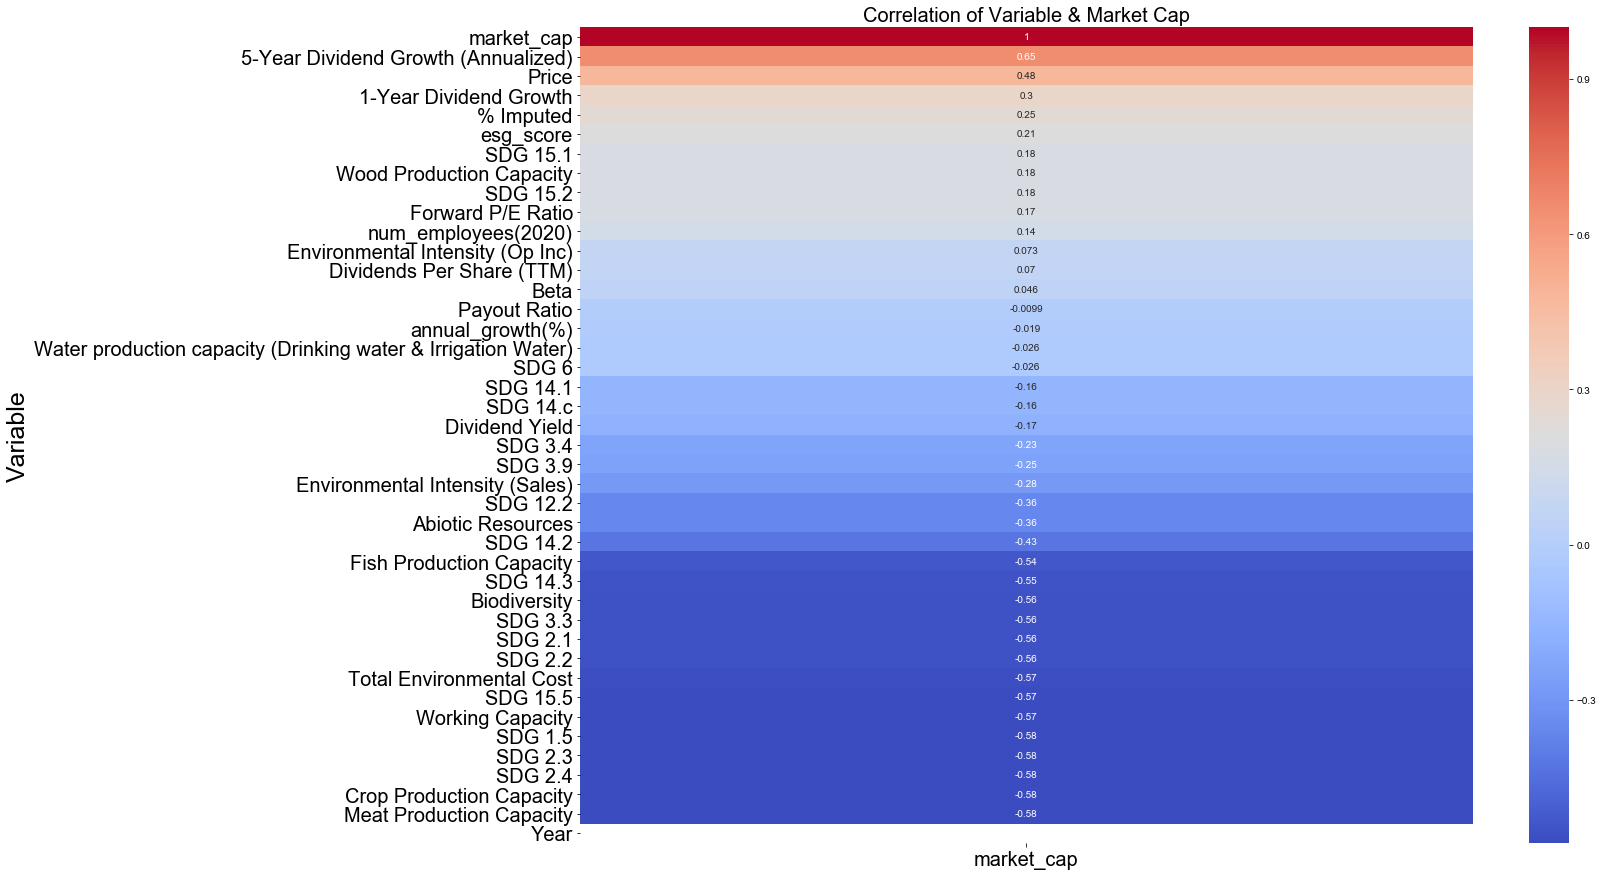

In [11]:
# Correlation of Market Cap

corr_points = df.corr()[['market_cap']].sort_values('market_cap', ascending=False)

plt.figure(figsize = (20,15))
ax = sns.heatmap(corr_points, annot=True, cmap='coolwarm')

ax.set_ylabel('Variable', fontsize = 25.0)
ax.set_title('Correlation of Variable & Market Cap', fontsize = 20)
ax.tick_params(axis="x", labelsize=20)
ax.tick_params(axis="y", labelsize=20, labelrotation=0)
sns.set(font_scale=1)

In [12]:
# Took variables that have a correlation coefficient to market_cap that is x < -0.1 and x > 0.1
# These are variables I would at most include in my model

model_variables = corr_points[(corr_points['market_cap'] > 0.1)].index.to_list() + corr_points[(corr_points['market_cap'] < -0.1)].index.to_list()

model_variables

['market_cap',
 '5-Year Dividend Growth (Annualized)',
 'Price',
 '1-Year Dividend Growth',
 '% Imputed',
 'esg_score',
 'SDG 15.1',
 'Wood Production Capacity',
 'SDG 15.2',
 'Forward P/E Ratio',
 'num_employees(2020)',
 'SDG 14.1',
 'SDG 14.c',
 'Dividend Yield',
 'SDG 3.4',
 'SDG 3.9',
 'Environmental Intensity (Sales)',
 'SDG 12.2',
 'Abiotic Resources',
 'SDG 14.2',
 'Fish Production Capacity',
 'SDG 14.3',
 'Biodiversity',
 'SDG 3.3',
 'SDG 2.1',
 'SDG 2.2',
 'Total Environmental Cost',
 'SDG 15.5',
 'Working Capacity',
 'SDG 1.5',
 'SDG 2.3',
 'SDG 2.4',
 'Crop Production Capacity',
 'Meat Production Capacity']

#### Market Cap vs. Environmental Cost
- Ideally, companies would have a higher market cap and lower environmental cost. Three companies that seem to fit this criteria are:
        1. AVIS Budget Group
        2. Tetra Tech Inc.
        3. International Game Technology PLC.
- Alcoa Corp has higher than \\$7 Billion USD Market Cap, but also has a monetized environmental impact of over -\\$7 Billion USD.

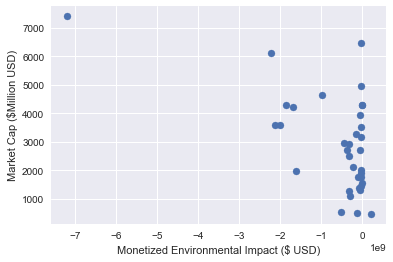

In [13]:
x = df['Total Environmental Cost']
y = df['market_cap']

plt.xlabel('Monetized Environmental Impact ($ USD)')
plt.ylabel('Market Cap ($Million USD)')
plt.scatter(x,y)
plt.show()

In [14]:
# AVIS Budget Group & Tetra Tech Inc. & International Game Technology PLC. are three
# companies that have a high market cap while maintaining a relatively low environmental cost.

df.loc[(df['market_cap'] > 4500) & (df['Total Environmental Cost'] > -3e+09)] 

,Year,name,Country,Industry (Exiobase),Environmental Intensity (Sales),Environmental Intensity (Op Inc),Total Environmental Cost,Working Capacity,Fish Production Capacity,Crop Production Capacity,...,1-Year Dividend Growth,5-Year Dividend Growth (Annualized),Dividends Per Share (TTM),market_cap,Forward P/E Ratio,Payout Ratio,Beta,num_employees(2020),annual_growth(%),esg_score
15,2019,goodyear tire & rubber co.,United States,Manufacture of rubber and plastic products (25),-0.066755,-1.514308,-9.843005e+08,-8.222630e+08,-186529.786587,-1.108086e+07,...,NaN,NaN,0.00000,4659.655224,NaN,0.000000,1.593471,62000,-0.0159,55
19,2019,avis budget group inc,United States,Other land transport,-0.241055,-2.654209,-2.210956e+09,-2.163001e+09,-494649.163290,-2.876727e+07,...,NaN,NaN,0.00000,6135.000870,NaN,0.000000,2.022770,20000,-0.3333,46
30,2019,"tetra tech, inc.",United States,Real estate activities (70),-0.004435,-0.050962,-1.059779e+07,-1.037699e+07,-2576.612223,-1.314536e+05,...,0.176471,0.173161,0.70873,6470.537373,34.39854,0.206026,1.157291,20000,0.0000,72
31,2019,international game technology plc,United States,"Recreational, cultural and sporting activities...",-0.006358,-0.041129,-3.043001e+07,-2.832690e+07,-6311.078428,-3.321050e+05,...,NaN,NaN,0.00000,4969.820243,NaN,0.000000,2.064792,11048,-0.0733,75


In [15]:
# High Market Cap, High Environmental Cost

df.loc[(df['market_cap'] > 4500) & (df['Total Environmental Cost'] < -3e+09)] 

,Year,name,Country,Industry (Exiobase),Environmental Intensity (Sales),Environmental Intensity (Op Inc),Total Environmental Cost,Working Capacity,Fish Production Capacity,Crop Production Capacity,...,1-Year Dividend Growth,5-Year Dividend Growth (Annualized),Dividends Per Share (TTM),market_cap,Forward P/E Ratio,Payout Ratio,Beta,num_employees(2020),annual_growth(%),esg_score
18,2019,alcoa corp,United States,Mining of other non-ferrous metal ores and con...,-0.691766,-8.238812,-7.217200e+09,-7.105545e+09,-2.078122e+06,-8.891028e+07,...,NaN,NaN,0.0,7407.370634,NaN,0.0,1.749593,12900,-0.0652,88


### Sentiment Analysis
- Will create a general skeleton outline for now.

In [ ]:
# Instantiating sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Functions to get certain attributes of the polarity scores.
def get_compound(text):
    return sia.polarity_scores(text)['compound']

def get_neg(text):
    return sia.polarity_scores(text)['neg']

def get_pos(text):
    return sia.polarity_scores(text)['pos']

# Applying the sentiment analysis functions and adding it to dataframe
df['sentiment_reviews'] = df['reviews'].apply(get_compound)
df['sentiment_news_headers'] = df['news_headers'].apply(get_compound)

### Modeling
- I will build a regression model with the goal of being able to predict a company's market cap.
- Looking at the columns that are missing data, it would be inappropriate for me to impute the missing data for Forward P/E because it's based on estimates of future earnings which would be different by company. Additionally, Forward P/E is not reported for many of the companies. For these reasons, I will drop Forward P/E from my analysis.
- For the dividend growth, we can assume that if there's a NaN value, then it should be 0.
- Also will drop market_cap from the list of modeling_variables because it's the target.

In [16]:
df[model_variables].isna().sum()

market_cap                              0
5-Year Dividend Growth (Annualized)    22
Price                                   0
1-Year Dividend Growth                 22
% Imputed                               0
esg_score                               0
SDG 15.1                                0
Wood Production Capacity                0
SDG 15.2                                0
Forward P/E Ratio                      16
num_employees(2020)                     0
SDG 14.1                                0
SDG 14.c                                0
Dividend Yield                          0
SDG 3.4                                 0
SDG 3.9                                 0
Environmental Intensity (Sales)         0
SDG 12.2                                0
Abiotic Resources                       0
SDG 14.2                                0
Fish Production Capacity                0
SDG 14.3                                0
Biodiversity                            0
SDG 3.3                           

In [17]:
# Looking at the columns that are missing data, it would be inappropriate for me to impute the missing data
# for Forward P/E because it's based on estimates of future earnings which would be different by company. Additionally,
# Forward P/E is not reported for many of the companies. For these reasons, I will drop Forward P/E from my analysis.
# For the dividend growth, we can assume that if there's a NaN value, then it should be 0.

df.loc[df['5-Year Dividend Growth (Annualized)'].isna(), ['5-Year Dividend Growth (Annualized)', '1-Year Dividend Growth']] = 0
df.drop('Forward P/E Ratio', axis=1, inplace=True)

model_variables_delete = ['Forward P/E Ratio', 'market_cap']

for variable in model_variables_delete:
    model_variables.remove(variable)

In [18]:
# Train-Test Splitting

X = df[model_variables]
y = df['market_cap']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)

In [19]:
lr = LinearRegression()
lr.fit(X_train, y_train)

train_score = str(lr.score(X_train, y_train))
test_score = str(lr.score(X_test, y_test))
cross_value_mean = str(cross_val_score(lr, X_train, y_train, cv=3).mean())

print('Train R^2 Score: '+ train_score)
print('Test R^2 Score: '+ test_score)
print('Mean of Cross Value Scores: '+ cross_value_mean)

Train R^2 Score: 0.8945631863881106
Test R^2 Score: 0.26688093368630683
Mean of Cross Value Scores: -581651.9387185605


### Predictions & Residuals

In [20]:
preds = lr.predict(X_test)
residuals = y_test - preds

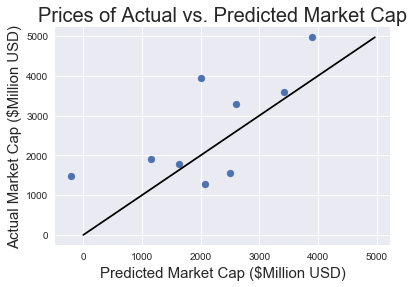

In [21]:
plt.scatter(preds, y_test)
plt.xlabel('Predicted Market Cap ($Million USD)', fontsize = 15)
plt.ylabel('Actual Market Cap ($Million USD)', fontsize = 15)
plt.title('Prices of Actual vs. Predicted Market Cap', fontsize = 20)

plt.plot([0, np.max(y_test)],
         [0, np.max(y_test)],
         color = 'black');